In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import ttest_rel  # For statistical test
from sklearn.feature_extraction.text import TfidfVectorizer  # Fixed import name
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\DELL
[nltk_data]     5540\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\DELL
[nltk_data]     5540\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
df = pd.read_excel('ChatGPT Vs SouLLMate.xlsx', sheet_name='Sheet1')

# Clean Arabic text
def clean_arabic_text(text):
    # Remove diacritics and punctuation
    text = text.replace('،', '').replace('؛', '').replace('؟', '')
    # Remove stopwords
    stop_words = set(stopwords.words('arabic'))
    words = word_tokenize(text)
    cleaned = [word for word in words if word not in stop_words]
    return ' '.join(cleaned)

# Apply cleaning
df['cleaned_chatgpt'] = df['إجابة ChatGPT'].apply(clean_arabic_text)
df['cleaned_soullmate'] = df['إجابة SouLLMate'].apply(clean_arabic_text)


In [45]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

# ====== REPLACE get_embedding() FUNCTION ======
def get_batch_embeddings(texts):  # NEW: Batch processing
    inputs = tokenizer(
        texts, 
        return_tensors='pt', 
        padding=True, 
        truncation=True, 
        max_length=512
    )
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Calculate similarities using batches
chatgpt_texts = df['cleaned_chatgpt'].tolist()
soullmate_texts = df['cleaned_soullmate'].tolist()

chatgpt_embs = get_batch_embeddings(chatgpt_texts)  # NEW
soullmate_embs = get_batch_embeddings(soullmate_texts)  # NEW

similarities = [
    1 - cosine(emb1, emb2) 
    for emb1, emb2 in zip(chatgpt_embs, soullmate_embs)  # NEW
]

df['semantic_similarity'] = similarities

In [46]:
print("ChatGPT Mean Accuracy:", df['نسبة الدقة لـ ChatGPT'].mean())
print("SouLLMate Mean Accuracy:", df['نسبة الدقة لـ SouLLMate'].mean())
print("Mean Semantic Similarity:", np.mean(similarities))


ChatGPT Mean Accuracy: 0.9366666666666665
SouLLMate Mean Accuracy: 0.9133333333333334
Mean Semantic Similarity: 0.8546310464541117


In [47]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to C:\Users\DELL
[nltk_data]     5540\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [48]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import nltk

# Ensure required NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # <-- Added to download the missing resource

smoother = SmoothingFunction()

bleu_scores = []
for idx, row in df.iterrows():
    ref = word_tokenize(row['cleaned_chatgpt'])
    cand = word_tokenize(row['cleaned_soullmate'])
    bleu_scores.append(
        sentence_bleu([ref], cand, smoothing_function=smoother.method4)
    )
df['BLEU_score'] = bleu_scores

# Wrap the tokenizer function in a class for RougeScorer
from nltk.tokenize import wordpunct_tokenize

class ArabicTokenizer:
    def tokenize(self, text):
        return wordpunct_tokenize(text)

arabic_tokenizer_instance = ArabicTokenizer()

scorer = rouge_scorer.RougeScorer(
    ['rouge1', 'rougeL'], 
    tokenizer=arabic_tokenizer_instance
)


rouge_scores = []
for idx, row in df.iterrows():
    scores = scorer.score(
        row['cleaned_chatgpt'], 
        row['cleaned_soullmate']
    )
    rouge_scores.append(scores['rougeL'].fmeasure)


[nltk_data] Downloading package punkt to C:\Users\DELL
[nltk_data]     5540\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\DELL
[nltk_data]     5540\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\DELL
[nltk_data]     5540\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


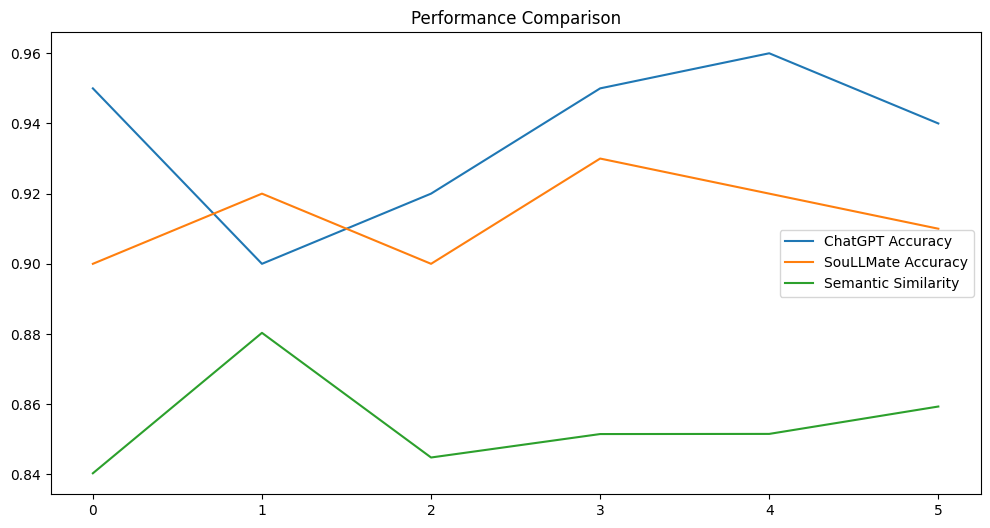

In [49]:
# ## 6. Visualization
plt.figure(figsize=(12,6))
plt.title('Performance Comparison')
plt.plot(df['نسبة الدقة لـ ChatGPT'], label='ChatGPT Accuracy')
plt.plot(df['نسبة الدقة لـ SouLLMate'], label='SouLLMate Accuracy')
plt.plot(df['semantic_similarity'], label='Semantic Similarity')
plt.legend()
plt.show()

In [50]:
# ## 7. Full Report
print("\n=== Final Report ===")
print(f"Average ChatGPT Accuracy: {df['نسبة الدقة لـ ChatGPT'].mean():.2f}")
print(f"Average SouLLMate Accuracy: {df['نسبة الدقة لـ SouLLMate'].mean():.2f}")
print(f"Average Semantic Similarity: {np.mean(similarities):.2f}")
print(f"Average BLEU Score: {np.mean(bleu_scores):.2f}")
print(f"Average ROUGE-L: {np.mean(rouge_scores):.2f}")


=== Final Report ===
Average ChatGPT Accuracy: 0.94
Average SouLLMate Accuracy: 0.91
Average Semantic Similarity: 0.85
Average BLEU Score: 0.02
Average ROUGE-L: 0.17


In [51]:
# ====== ADD TO FINAL REPORT SECTION ======
from scipy.stats import ttest_rel  # NEW

# Statistical test
t_stat, p_value = ttest_rel(
    df['نسبة الدقة لـ ChatGPT'], 
    df['نسبة الدقة لـ SouLLMate']
)
print(f"\nStatistical Significance (p-value): {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference in accuracies (p < 0.05)")
else:
    print("No significant difference in accuracies")


Statistical Significance (p-value): 0.0648
No significant difference in accuracies


In [53]:
# ====== REPLACE KEYWORD ANALYSIS SECTION ======
from sklearn.feature_extraction.text import TfidfVectorizer  # NEW

# Get all cleaned texts
all_texts = df['cleaned_chatgpt'].tolist() + df['cleaned_soullmate'].tolist()

# Train TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf.fit(all_texts)

def extract_tfidf_keywords(text, n=5):  # NEW
    words = word_tokenize(text)
    tfidf_scores = tfidf.transform([' '.join(words)])
    feature_index = tfidf_scores.nonzero()[1]
    scores = zip(feature_index, tfidf_scores.data)
    sorted_words = sorted(scores, key=lambda x: x[1], reverse=True)
    return [tfidf.get_feature_names_out()[i] for i, _ in sorted_words[:n]]

df['chatgpt_keywords'] = df['cleaned_chatgpt'].apply(extract_tfidf_keywords)
df['soullmate_keywords'] = df['cleaned_soullmate'].apply(extract_tfidf_keywords)